<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Coding AdaBoost from Scratch

---

In this lab we want to code the AdaBoost algorithm from scratch and verify our results by comparing to the sklearn implementation.

To get started, have a look at [Jaime Pastor](
https://github.com/jaimeps/adaboost-implementation/blob/master/adaboost.py).

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coding-AdaBoost-from-Scratch" data-toc-modified-id="Coding-AdaBoost-from-Scratch-1">Coding AdaBoost from Scratch</a></span><ul class="toc-item"><li><span><a href="#AdaBoost-main-points" data-toc-modified-id="AdaBoost-main-points-1.1">AdaBoost main points</a></span><ul class="toc-item"><li><span><a href="#The-Adaboost-algorithm" data-toc-modified-id="The-Adaboost-algorithm-1.1.1">The Adaboost algorithm</a></span></li><li><span><a href="#Write-a-scoring-function" data-toc-modified-id="Write-a-scoring-function-1.1.2">Write a scoring function</a></span></li><li><span><a href="#Write-a-model-prediction-function" data-toc-modified-id="Write-a-model-prediction-function-1.1.3">Write a model prediction function</a></span></li><li><span><a href="#Write-a-function-which-returns-training-and-test-scores" data-toc-modified-id="Write-a-function-which-returns-training-and-test-scores-1.1.4">Write a function which returns training and test scores</a></span></li><li><span><a href="#Write-an-indicator-function" data-toc-modified-id="Write-an-indicator-function-1.1.5">Write an indicator function</a></span></li><li><span><a href="#Calculate-the-error-rate" data-toc-modified-id="Calculate-the-error-rate-1.1.6">Calculate the error rate</a></span></li><li><span><a href="#Write-a-function-for-calculating-the-current-alpha-from-the-error-rate" data-toc-modified-id="Write-a-function-for-calculating-the-current-alpha-from-the-error-rate-1.1.7">Write a function for calculating the current alpha from the error rate</a></span></li><li><span><a href="#Write-a-function-for-updating-the-importance-weights" data-toc-modified-id="Write-a-function-for-updating-the-importance-weights-1.1.8">Write a function for updating the importance weights</a></span></li><li><span><a href="#Write-a-function-for-updating-the-predictions-at-each-iteration-step" data-toc-modified-id="Write-a-function-for-updating-the-predictions-at-each-iteration-step-1.1.9">Write a function for updating the predictions at each iteration step</a></span></li><li><span><a href="#Write-a-function-which-converts-[0,1]-labels-to-[-1,1]-labels" data-toc-modified-id="Write-a-function-which-converts-[0,1]-labels-to-[-1,1]-labels-1.1.10">Write a function which converts [0,1]-labels to [-1,1]-labels</a></span></li><li><span><a href="#Create-your-adaboost-model" data-toc-modified-id="Create-your-adaboost-model-1.1.11">Create your adaboost model</a></span></li><li><span><a href="#Fit-the-model" data-toc-modified-id="Fit-the-model-1.1.12">Fit the model</a></span></li><li><span><a href="#Check-your-model-on-these-datasets" data-toc-modified-id="Check-your-model-on-these-datasets-1.1.13">Check your model on these datasets</a></span></li><li><span><a href="#Compare-your-results-to-the-ones-obtained-with-sklearn." data-toc-modified-id="Compare-your-results-to-the-ones-obtained-with-sklearn.-1.1.14">Compare your results to the ones obtained with sklearn.</a></span></li></ul></li><li><span><a href="#Bonus:-Construct-a-class-out-of-your-model-fitting-function" data-toc-modified-id="Bonus:-Construct-a-class-out-of-your-model-fitting-function-1.2">Bonus: Construct a class out of your model fitting function</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2, make_moons
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## AdaBoost main points

---

Recall,

$$ {\rm AdaBoost}(X) = {\rm sign}\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $$

where

- ${\rm AdaBoost}(X)$ are the classification predictions for $y$ using the predictor matrix $X$

- $T$ is the set of "weak learners"

- $\alpha_t$ is the contribution weight for weak learner $t$

- $h_t(X)$ is the prediction of weak learner $t$

- $y$ is binary **with values -1 and 1**

### The Adaboost algorithm

- initialize weights $w_0=1/N$ ($N$ is the number of observations)
- for t=1:T do
    - Fit a classifier $h_t(X)$ to the training set $X$ using weights $w$
    - Compute the error rate 
$\epsilon_t = \frac{\sum_{i=1}^N w_{i,t} {I}(y_i\neq h_t(X_i))}{\sum_{i=1}^N w_{i,t}} $
    - Compute $ \alpha_t = \log \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$
    - Set $ w_{t+1,i} = w_{t,i} e^{\alpha_t  {I}(y_i\neq h_t(X_i))} $
- Return $ {\rm AdaBoost}(X) = {\rm sign}\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $

### Write a scoring function

We will need a function which calculates any specific score given true and predicted labels.

In [3]:
def get_score(y, pred, score=accuracy_score):
    """
    arguments: target values and predicted values
    returns: score
    """
    return score(y, pred)

### Write a model prediction function

Write a function which takes a model, training and test sets and sample weights. In the function body, fit the model, make prediction for training and test set and return them.

Hint: Use `model.fit(X_train, y_train, sample_weight=sample_weight)` to take the weights into account.

In [4]:
def model_predictions(y_train, X_train, y_test, X_test, model, sample_weight=None):
    """
    arguments: model, training and test sets, sample weights
    body: fit the model and make predicitions
    returns: training predictions and test predictions
    """
    model.fit(X_train, y_train, sample_weight=sample_weight)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    return pred_train, pred_test

### Write a function which returns training and test scores

This combines the previous two functions.

In [5]:
def generic_model(y_train, X_train, y_test, X_test, model):
    """
    arguments: train and test sets for X, y and a model
    fits the model on the training data and obtains train/test predictions
    returns: train/test scores
    """
    pred_train, pred_test = model_predictions(
        y_train, X_train, y_test, X_test, model)
    
    return get_score(y_train, pred_train), \
        get_score(y_test, pred_test)

### Write an indicator function
It should return 1 for disagreement between true and predicted labels and 0 otherwise.

In [6]:
def indicator_function(y, pred):
    """
    arguments: target variable and predicted values
    returns: 1 if disagreement, 0 else
    """
    return (pred != y) * 1

### Calculate the error rate

$$\epsilon_t = \frac{\sum_{i=1}^N w_{i,t} {I}(y_i\neq h_t(X_i))}{\sum_{i=1}^N w_{i,t}}$$

Make use of your indicator function.

In [7]:
def calculate_error_rate(w, miss):
    """
    arguments: weights and mask for misclassified data points (miss)
    returns: error rate
    """
    error_rate = np.dot(w, miss) / w.sum()
    return error_rate

### Write a function for calculating the current alpha from the error rate

$ \alpha_t = \log \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$

In [8]:
def calculate_alpha(error_rate):
    """
    calculates the alpha value at current iteration step
    argument: error rate
    returns: alpha_m
    """
    alpha_t = np.log((1. - error_rate) / error_rate)
    return alpha_t

### Write a function for updating the importance weights

$ w_{t+1,i} = w_{t,i} e^{\alpha_t  {I}(y_i\neq h_t(X_i))} $

In [9]:
def update_importance_weights(w, miss, alpha_t):
    """
    arguments: current weights, mask for misclassified observations, alpha_m
    returns: w, the updated weight
    """
    w = np.multiply(w, np.exp([float(x) * alpha_t for x in miss]))
    return w

### Write a function for updating the predictions at each iteration step

$\sum_{t=1}^T\alpha_t h_t(X)$

In [10]:
def update_predictions(pred, pred_t, alpha_t):
    """
    update the predictions with the ones of the current model
    arguments: previous aggregated predictions (pred), 
               predictions at current iteration,
               alpha_m
    returns: updated predictions
    """
    
    pred = [sum(p) for p in zip(pred, [m * alpha_t for m in pred_t])]
    return pred

### Write a function which converts [0,1]-labels to [-1,1]-labels

In [11]:
def binary_converter(y):
    return np.array([x if x == 1 else -1 for x in y])

### Create your adaboost model

This function combines the helper functions from above.

In [12]:
def adaboost_model(y_train, X_train, y_test, X_test, M, model):
    """
    adaboost implementation
    arguments: train/test X and y, number of iterations M, model
    returns: model train/test scores
    """
    # measure size of train/test sets
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    # Initialize train/test predictions
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    # convert labels to 1/-1
    ytilde_train = binary_converter(y_train)
    ytilde_test = binary_converter(y_test)
    
    for i in range(M):
        # Fit a classifier with the current weights
        pred_train_i, pred_test_i = model_predictions(
            y_train, X_train, y_test, X_test,
            model, sample_weight=w)
        
        # convert predicted labels to 1/-1
        pred_train_i = binary_converter(pred_train_i)
        pred_test_i = binary_converter(pred_test_i)
        # Indicator function
        miss = indicator_function(pred_train_i, ytilde_train)
        # Error
        err_m = calculate_error_rate(w, miss)
        # Alpha
        alpha_m = calculate_alpha(err_m)
        # update weights
        w = update_importance_weights(w, miss, alpha_m)
        # Add to prediction
        pred_train = update_predictions(pred_train, pred_train_i, alpha_m)
        pred_test = update_predictions(pred_test, pred_test_i, alpha_m)

    # get the sign of train/test predictions
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    
    # Return train/test scores
    return get_score(ytilde_train, pred_train), \
        get_score(ytilde_test, pred_test)

### Fit the model 

- Instantiate a classification model (decision tree)
- Loop over a number of iteration steps
- Obtain the training and test scores at each iteration step

In [13]:
def fit_model(model, X_train, y_train, X_test, y_test, iterations=10):
    

    # Fit a simple decision tree first

    #er_tree = generic_model(y_train, X_train, y_test, X_test, model)

    # Fit Adaboost classifier using a decision tree as base estimator
    # Test with different number of iterations
    er_train, er_test = [], []  


    x_range = range(1, iterations+1)
    for i in x_range:
        er_i = adaboost_model(y_train, X_train, y_test, X_test, i, model)
        er_train.append(er_i[0])
        er_test.append(er_i[1])

    return er_train, er_test

In [14]:
def plot_scores(y_1, y_2, y_3, y_4, iterations):
    
    x_range = range(1, iterations+1)
    
    fig, ax = plt.subplots()
    ax.plot(x_range, y_1, ls='--', lw=2, label='train')
    ax.plot(x_range, y_2, ls='--', lw=2, label='test')
    ax.plot(x_range, y_3, alpha=0.5, lw=2)
    ax.plot(x_range, y_4, alpha=0.5, lw=2)
    ax.set_xlabel('iterations')
    ax.set_ylabel('accuracy')
    ax.legend()
    return fig, ax

### Check your model on these datasets

1.

```python 
data = load_breast_cancer()
X = data.data
y = data.target
```  

2. 

```python
X, y = make_hastie_10_2(random_state=1)
```

3.
```python
X, y = make_moons(n_samples=100, noise=0.1, random_state=1)
```

### Compare your results to the ones obtained with sklearn.


```python
from sklearn.ensemble import AdaBoostClassifier
```

Hint: It is essential that you set

```python
algorithm='SAMME'
```

In [15]:
# choose from ['breast','hastie','moons']
choose_data = 'hastie'

if choose_data == 'breast':
    data = load_breast_cancer()
    X = data.data
    y = data.target
elif choose_data == 'hastie':
    X, y = make_hastie_10_2(random_state=1)
elif choose_data == 'moons':
    X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

In [16]:
from sklearn.datasets import load_breast_cancer

Own model and sklearn agree on the training set: True
Own model and sklearn agree on the test set: True


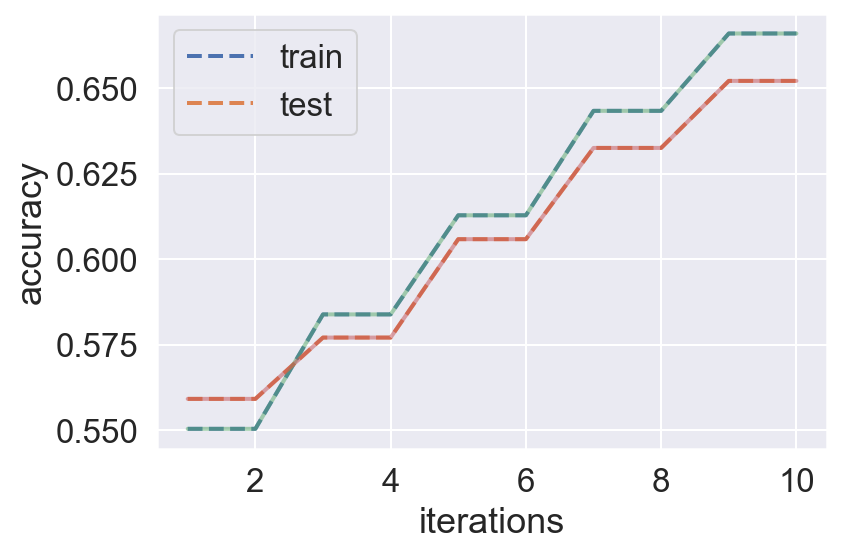

In [17]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = DecisionTreeClassifier(max_depth=1, random_state=1)

er_train, er_test = fit_model(model, X_train, y_train, X_test, y_test, iterations=10)

iterations = 10
ada = AdaBoostClassifier(base_estimator=model,
                         n_estimators=iterations, 
                         algorithm='SAMME')
ada.fit(X_train, y_train)

y_1 = np.array(er_train) 
y_2 = np.array(er_test)
y_3 = np.array(list(ada.staged_score(X_train, y_train)))
y_4 = np.array(list(ada.staged_score(X_test, y_test)))

print('Own model and sklearn agree on the training set:',
      np.allclose(y_1, y_3))
print('Own model and sklearn agree on the test set:',
      np.allclose(y_2, y_4))

fig, ax = plot_scores(y_1, y_2, y_3, y_4, iterations)

## Bonus: Construct a class out of your model fitting function


Think carefully how you would structure your class using the functions from above.

In [18]:
import adaboost_class as ada_class

In [19]:
ada.score(X_train, y_train), ada.score(X_test, y_test)

(0.6659375, 0.6520833333333333)

In [20]:
iterations = 10
ada_1 = ada_class.ada_boost_class(n_estimators=iterations)
ada_1.score(X_train, y_train, X_test, y_test)

(0.6659375, 0.6520833333333333)